# Rarity vs Last Price

In [1]:
"""
Update Parameters Here
"""
COLLECTION_NAME = "MekaVerse"
CONTRACT = "0x9a534628b4062e123ce7ee2222ec20b86e16ca8f"
LAST_N_EVENTS = 150

GRIFTER_ADDRESS = ""  # optional overlay of grifter sales on map (grifter sales must have occured in last 'LAST_N_EVENTS' sales)

In [2]:
"""
@author: mdigi14
"""
import datetime
from typing import Any, Dict, List

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from honestnft_utils import opensea
from honestnft_utils import constants
from honestnft_utils import config


RARITY_DB = pd.read_csv(f"{config.RARITY_FOLDER}/{COLLECTION_NAME}_raritytools.csv")


sales = []

"""
Plot params
"""
plt.rcParams.update({"figure.facecolor": "white", "savefig.facecolor": "white"})

"""
Helper Functions
"""


def get_opensea_data(contract: str, continuous: bool) -> List[Dict[str, Any]]:

    data = opensea.get_opensea_events(
        contract_address=contract,
        event_type="successful",
        continuous=continuous,
    )
    return data

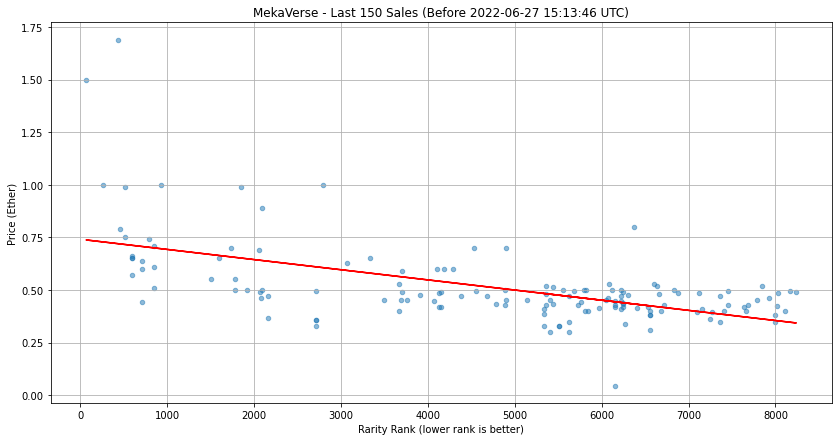

In [3]:
"""
Generate Plot
"""
if LAST_N_EVENTS <= constants.OPENSEA_MAX_LIMIT:
    events = get_opensea_data(CONTRACT, continuous=False)
else:
    events = get_opensea_data(CONTRACT, continuous=True)

events = events[:LAST_N_EVENTS]
for event in events:
    try:
        token_id = int(event["asset"]["token_id"])
        sale = dict()
        sale["TOKEN_ID"] = token_id
        sale["USER"] = event["transaction"]["from_account"]["address"]
        sale["SELLER"] = event["seller"]["address"]
        sale["DATE"] = event["created_date"]
        sale["RANK"] = int(RARITY_DB[RARITY_DB["TOKEN_ID"] == token_id]["Rank"])
        sale["PRICE"] = float(event["total_price"]) / constants.ETHER_UNITS  # type: ignore

    except:
        continue

    sales.append(sale)


df = pd.DataFrame(sales)
df = df[df["RANK"].notna()]
df.to_csv(f"{config.ROOT_DATA_FOLDER}/recent_sales.csv")

X = df["RANK"].values.reshape(-1, 1)
Y = df["PRICE"].values.reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(X, Y)
Y_pred = linear_regressor.predict(X)

df = df.sort_values(by="RANK")
ax = df.plot.scatter(
    x="RANK",
    y="PRICE",
    grid=True,
    alpha=0.5,
    title=COLLECTION_NAME,
    figsize=(14, 7),
)

if GRIFTER_ADDRESS != "":
    GRIFTER_DB = df[df["SELLER"] == GRIFTER_ADDRESS]
    ranks = GRIFTER_DB["RANK"]
    prices = GRIFTER_DB["PRICE"]
    plt.scatter(x=ranks, y=prices, color="black", s=25)

plt.plot(X, Y_pred, color="red")
plt.xlabel("Rarity Rank (lower rank is better)")
plt.ylabel("Price (Ether)")
plt.title(
    f"{COLLECTION_NAME} - Last {LAST_N_EVENTS} Sales (Before {datetime.datetime.now(datetime.timezone.utc).strftime('%Y-%m-%d %H:%M:%S %Z')})"
)
plt.savefig(f"{config.FIGURES_FOLDER}/{COLLECTION_NAME}_price_vs_rank.png")
plt.show()